<a href="https://colab.research.google.com/github/Michal287/computer_vision/blob/main/FasterRCNN_MobileNet_Detection_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.9.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 386602, done.
remote: Counting objects: 100% (36842/36842), done.
remote: Compressing objects: 100% (1979/1979), done.
remote: Total 386602 (delta 34830), reused 36658 (delta 34746), pack-reused 349760
Receiving objects: 100% (386602/386602), 765.67 MiB | 22.84 MiB/s, done.
Resolving deltas: 100% (357356/357356), done.
Note: switching to 'v0.9.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 01dfa8ea81 add custom user agent for download_url (#3499)


In [ ]:
!pip install torch==1.11.0
!pip install torchvision==0.12.0
exit(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 20.8 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2+cu118
    Uninstalling torchvision-0.15.

In [ ]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}, torchvision version: {torchvision.__version__}")

Torch version: 1.11.0+cu102, torchvision version: 0.12.0+cu102


# Imports

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image

import os
import random
import json
from google.colab import drive

from pycocotools.coco import COCO

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Check GPU

In [ ]:
!nvidia-smi

Thu Sep  7 12:36:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Pytorch device: {device}")

Pytorch device: cuda


# Downloand data

In [ ]:
drive.mount('/content/drive')

!7z x /content/drive/MyDrive/source.zip -odata/images
!7z x /content/drive/MyDrive/source2.zip -odata/images

!7z x /content/drive/MyDrive/annotations.zip -odata/annotations

Mounted at /content/drive

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 583322523 bytes (557 MiB)

Extracting archive: /content/drive/MyDrive/source.zip
--
Path = /content/drive/MyDrive/source.zip
Type = zip
Physical Size = 583322523

  0%      1% 3 - source/image_100.png                               2% 5 - source/image_102.png                               3% 8 - source/image_105.png                               4% 10 - source/image_107.png                

# Work with nested files

In [ ]:
from pycocotools.coco import COCO
import os
import json

def coco_prefix(coco_details):
    for coco_detail in coco_details:
        coco_file = coco_detail['coco_file']
        full_path = coco_detail['prefix_path']

        coco = COCO(coco_file)

        # Zastąp ścieżkę obrazu podaną pełną ścieżką
        for img_id, img_data in coco.imgs.items():
            img_name = os.path.basename(img_data["file_name"])
            img_data["file_name"] = os.path.join(full_path, img_name)

        # Zapisz zmodyfikowane dane z powrotem do pliku
        with open(coco_file, 'w') as f:
            json.dump(coco.dataset, f)

# Użyj funkcji
coco_details = [
    {'coco_file': '/content/data/annotations/source.json', 'prefix_path': 'source'},
    {'coco_file': '/content/data/annotations/source2.json', 'prefix_path': 'source2'}
]

coco_prefix(coco_details)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# Merge files

In [ ]:
from pycocotools.coco import COCO
import os

def merge_coco_files(files):
    merged_data = {}
    img_id_offset = 0
    ann_id_offset = 0

    for file in files:
        coco = COCO(file)

        if not merged_data:
            merged_data = coco.dataset
            img_id_offset += len(coco.getImgIds())
            ann_id_offset += len(coco.getAnnIds())
            continue

        # Zmiana ID obrazów
        for img in coco.dataset['images']:
            img['id'] += img_id_offset

        # Zmiana ID anotacji
        for ann in coco.dataset['annotations']:
            ann['image_id'] += img_id_offset
            ann['id'] += ann_id_offset

        # Scalenie obrazów
        merged_data['images'].extend(coco.dataset['images'])

        # Scalenie anotacji
        merged_data['annotations'].extend(coco.dataset['annotations'])

        img_id_offset += len(coco.getImgIds())
        ann_id_offset += len(coco.getAnnIds())

    return merged_data

files = ['/content/data/annotations/source.json', '/content/data/annotations/source2.json']  # i tak dalej
merged_data = merge_coco_files(files)

with open('merged_coco.json', 'w') as f:
    json.dump(merged_data, f)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


# COCO train test split

In [ ]:
import json
from pycocotools.coco import COCO
import random
import os

def train_test_split(coco_path, output_dir, validation_split=0.2):
    data = COCO(coco_path).dataset

    # Wczytaj wszystkie identyfikatory obrazów
    image_ids = [img_info["id"] for img_info in data["images"]]
    assert len(image_ids) == len(set(image_ids)), "There are duplicate IDs in the original data."

    # Losowo przypisz identyfikatory obrazów do zbioru treningowego i walidacyjnego
    num_images = len(image_ids)
    num_validation = int(validation_split * num_images)
    validation_ids = random.sample(image_ids, num_validation)
    training_ids = list(set(image_ids) - set(validation_ids))

    # Podziel dane na zbiory treningowy i walidacyjny
    training_data = {
        "images": [img_info for img_info in data["images"] if img_info["id"] in training_ids],
        "annotations": [ann_info for ann_info in data["annotations"] if ann_info["image_id"] in training_ids],
        "categories": data["categories"]
    }

    validation_data = {
        "images": [img_info for img_info in data["images"] if img_info["id"] in validation_ids],
        "annotations": [ann_info for ann_info in data["annotations"] if ann_info["image_id"] in validation_ids],
        "categories": data["categories"]
    }

    # Assert to make sure there are no overlapping IDs between training and validation data
    assert not (set(training_ids) & set(validation_ids)), "Overlap detected between training and validation IDs."

    # Save the data
    for filename, output_data in [('training_data.json', training_data), ('validation_data.json', validation_data)]:
        full_path = os.path.join(output_dir, filename)

        with open(full_path, "w") as f:
            json.dump(output_data, f)

train_test_split('/content/merged_coco.json', '/content', validation_split=0.2)
#train_test_split('/content/data/annotations/source.json', '/content/data/annotations', validation_split=0.2)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


# Dataset

In [ ]:
class CocoImageDataset(Dataset):
    def __init__(self, coco_annotations_file, image_dir, transforms=None):
        self.coco = coco_annotations_file
        self.transforms = transforms
        self.image_ids = self.coco.getImgIds()
        self.image_dir = image_dir

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_info = self.coco.loadImgs(self.image_ids[idx])[0]

        image_path = os.path.join(self.image_dir, img_info['file_name'])

        # Wczytanie obrazu z pliku
        img = Image.open(image_path)

        # Przykład: zakładamy, że pliki zdjęć są w formacie RGB
        img = img.convert("RGB")

        # Pobierz informacje o bounding boxach i etykietach dla obrazu
        ann_ids = self.coco.getAnnIds(imgIds=self.image_ids[idx])
        annotations = self.coco.loadAnns(ann_ids)

        # Pobierz etykiety klas obiektów i bounding boxy
        labels = []
        boxes = []

        for ann in annotations:
            bbox = ann['bbox']
            xmin = int(bbox[0])
            ymin = int(bbox[1])
            xmax = int(bbox[0] + bbox[2])
            ymax = int(bbox[1] + bbox[3])
            boxes.append([xmin, ymin, xmax, ymax])


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(annotations),), dtype=torch.int64)

        image_id = img_info['id']
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(annotations),), dtype=torch.int64)

        if self.transforms is not None:
            data = {
                'image': np.array(img),          # obraz jako np.array lub PIL.Image
                'bboxes': np.array(boxes), # lista bounding boxów (x_min, y_min, x_max, y_max)
                'category_id': np.array(labels)  # lista etykiet klas
            }

            transformed = self.transforms(**data)
            img = transformed['image']
            boxes = transformed['bboxes']

        target = {}
        target["boxes"] = torch.tensor([[int(x1), int(y1), int(x2), int(y2)] for x1, y1, x2, y2 in boxes]).float()
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # if self.transforms is not None:
        #     img, target = self.transforms(img, target)

        return img, target

In [ ]:
from torchvision import utils
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_transform(train):
    transforms = []
    # Kolejność transformacji została zmieniona
    if train:
        transforms.append(A.HorizontalFlip(p=0.2))
        # transforms.append(A.VerticalFlip(p=0.2))
        transforms.append(A.Blur(blur_limit=2, p=0.25))
        transforms.append(A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.15, p=0.5))

    transforms.append(A.Resize(320, 320))
    transforms.append(A.Normalize(mean=[0, 0, 0], std=[255, 255, 255], max_pixel_value=1.0))
    transforms.append(ToTensorV2())
    bbox_params = A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['category_id'])
    return A.Compose(transforms, bbox_params=bbox_params)


train_dataset = CocoImageDataset(COCO('/content/training_data.json'), image_dir='/content/data/images/', transforms=get_transform(train=True))
validation_dataset = CocoImageDataset(COCO('/content/validation_data.json'), image_dir='/content/data/images/', transforms=get_transform(train=False))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
batch_size = 16

train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
validation_dataset_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# Check Data

In [ ]:
def validate_data(images, targets):
    # walidacja obrazów
    if not isinstance(images, torch.Tensor):
        raise ValueError("Images should be of type Tensor.")

    if not (images.dim() == 3 and images.size(0) == 3):
        raise ValueError("Images should have dimensions [3, H, W].")

    # walidacja targetów
    required_keys = ['boxes', 'labels']
    optional_keys = ['image_id', 'area', 'iscrowd']

    for t in targets:
        # sprawdź czy wszystkie wymagane klucze są obecne
        if not all(key in t for key in required_keys):
            raise ValueError(f"Target is missing one of the required keys {required_keys}")

        # sprawdź czy 'boxes' i 'labels' mają poprawny format
        if not (isinstance(t['boxes'], torch.Tensor) and t['boxes'].dim() == 2 and t['boxes'].size(1) == 4):
            raise ValueError("'boxes' should be a 2D Tensor with shape (_, 4).")

        if not (isinstance(t['labels'], torch.Tensor) and t['labels'].dim() == 1):
            raise ValueError("'labels' should be a 1D Tensor.")

        # jeśli istnieją, sprawdź poprawność opcjonalnych kluczy
        for key in optional_keys:
            if key in t:
                if not isinstance(t[key], torch.Tensor):
                    raise ValueError(f"'{key}' should be a Tensor.")

# Użyj funkcji do sprawdzenia danych podczas treningu
for images, targets in train_dataset_loader:
    try:
        for image in images:
            validate_data(image, targets)
            break
    except ValueError as e:
        print(f"Invalid format for data: {e}")
        continue

Invalid format for data: 'image_id' should be a Tensor.
Invalid format for data: 'image_id' should be a Tensor.


KeyboardInterrupt: ignored

# Show data

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def show_images(dataloader, num_images, figsize=(15, 15)):
    # Pobieramy batch z dataloader
    images, targets = next(iter(dataloader))

    # Wybieramy pierwsze `num_images` obrazów i targety
    images = images[:num_images]
    targets = targets[:num_images]

    # Obliczamy liczbę rzędów potrzebnych do wyświetlenia obrazów w 3 kolumnach
    num_rows = int(np.ceil(num_images / 3))

    fig = plt.figure(figsize=figsize)

    for i in range(num_images):
        ax = fig.add_subplot(num_rows, 3, i+1)

        # Przekształcamy obraz z tensora do formatu PIL i następnie do ndarray dla wyświetlenia w matplotlib
        img = transforms.ToPILImage()(images[i]).convert("RGB")
        img = np.array(img)

        # Rysujemy obraz
        ax.imshow(img)

        # Rysujemy bounding boxy
        for box in targets[i]['boxes']:
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)

        # Wyłączamy wyświetlanie osi
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_images(train_dataset_loader, 9)

# Load Model

In [ ]:
# Change in coco_utils [132] targets["image_id"].items() to targets["image_id"]
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import utils
from torchsummary import summary


model = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

# Inicjalizuj wagi dla nowej warstwy klasyfikacyjnej
from torch.nn.init import xavier_uniform_
xavier_uniform_(model.roi_heads.box_predictor.cls_score.weight)
torch.nn.init.constant_(model.roi_heads.box_predictor.cls_score.bias, 0)

model.train()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.937, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)


In [ ]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"]: output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {'images': [], 'categories': [], 'annotations': []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"]
        img_dict = {}
        img_dict['id'] = image_id
        img_dict['height'] = img.shape[-2]
        img_dict['width'] = img.shape[-1]
        dataset['images'].append(img_dict)
        bboxes = targets["boxes"]
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets['labels'].tolist()
        areas = targets['area'].tolist()
        iscrowd = targets['iscrowd'].tolist()
        if 'masks' in targets:
            masks = targets['masks']
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if 'keypoints' in targets:
            keypoints = targets['keypoints']
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann['image_id'] = image_id
            ann['bbox'] = bboxes[i]
            ann['category_id'] = labels[i]
            categories.add(labels[i])
            ann['area'] = areas[i]
            ann['iscrowd'] = iscrowd[i]
            ann['id'] = ann_id
            if 'masks' in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if 'keypoints' in targets:
                ann['keypoints'] = keypoints[i]
                ann['num_keypoints'] = sum(k != 0 for k in keypoints[i][2::3])
            dataset['annotations'].append(ann)
            ann_id += 1
    dataset['categories'] = [{'id': i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds


def get_coco_api_from_dataset(dataset):
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)

# Train

In [ ]:
# let's train it for 10 epochs
num_epochs = 15
epoch_train_history = []
epoch_val_history = []

for epoch in range(num_epochs):
    epoch_train_loss = train_one_epoch(model, optimizer, train_dataset_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()

    epoch_train_evaluate = evaluate(model, train_dataset_loader, device=device)
    epoch_train_history.append(epoch_train_evaluate)

    epoch_val_evaluate = evaluate(model, validation_dataset_loader, device=device)
    epoch_val_history.append(epoch_val_evaluate)
print("That's it!")

# Plot functions

In [ ]:
def get_results(history):
    results_labels = ['Average Precision IoU=0.50:0.95 area=all',
                  'Average Precision IoU=0.50 area=all',
                  'Average Precision IoU=0.75 area=all',
                  'Average Precision IoU=0.50:0.95 area=small',
                  'Average Precision IoU=0.50:0.95 area=medium',
                  'Average Precision IoU=0.50:0.95 area=large',
                  'Average Recall IoU=0.50:0.95 area=all',
                  'Average Recall IoU=0.50 area=all',
                  'Average Recall IoU=0.75 area=all',
                  'Average Recall IoU=0.50:0.95 area=small',
                  'Average Recall IoU=0.50:0.95 area=medium',
                  'Average Recall IoU=0.50:0.95 area=large']

    dict_results_precision = {key: [] for key in results_labels[:6]}
    dict_results_recall = {key: [] for key in results_labels[6:]}

    for results in history:
        scores = results.coco_eval['bbox'].stats

        for idx, label in enumerate(results_labels):
            if idx < 6:
                dict_results_precision[label].append(scores[idx])
            else:
                dict_results_recall[label].append(scores[idx])

    return dict_results_precision, dict_results_recall

train_results_precision, train_results_recall = get_results(epoch_train_history)
val_results_precision, val_results_recall = get_results(epoch_val_history)

In [ ]:
import matplotlib.pyplot as plt

def plot_in_grid(train_results, val_results, rows, cols):
    if len(train_results) != len(val_results):
        print("Błąd: listy train_results i val_results muszą mieć tę samą długość.")
        return

    if len(train_results) > rows * cols:
        print("Błąd: liczba kombinacji train_results i val_results jest większa niż liczba dostępnych miejsc w siatce.")
        return

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols,5*rows))

    if rows == 1:
        axes = [axes]
    if cols == 1:
        axes = [[ax] for ax in axes]

    for idx, (train_label, val_label) in enumerate(zip(train_results, val_results)):
        row = idx // cols
        col = idx % cols
        ax = axes[row][col]
        epochs = range(1, len(train_results[train_label]) + 1)

        # Rysuj stratę dla danych treningowych:
        ax.plot(epochs, train_results[train_label], 'r', label='Train')

        # Rysuj stratę dla danych walidacyjnych:
        ax.plot(epochs, val_results[val_label], 'b', label='Validation')

        # Dodaj tytuł i etykiety:
        ax.set_title(train_label)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()

    # Ukrywanie pustych subwykresów:
    for idx in range(len(train_results), rows*cols):
        row = idx // cols
        col = idx % cols
        axes[row][col].axis('off')

    plt.tight_layout()
    plt.show()

# Precison

In [ ]:
plot_in_grid(train_results_precision, val_results_precision, 2, 3)

# Recall

In [ ]:
plot_in_grid(train_results_recall, val_results_recall, 2, 3)

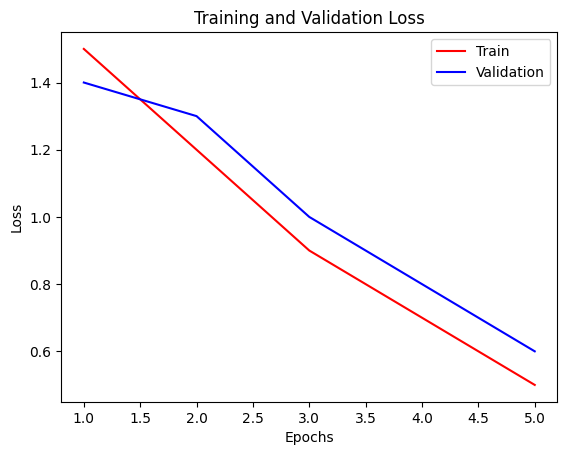

In [ ]:
import matplotlib.pyplot as plt

# Przykładowe dane:
train_losses = [1.5, 1.2, 0.9, 0.7, 0.5]
val_losses = [1.4, 1.3, 1.0, 0.8, 0.6]

# Utwórz zakres dla epok. Zakładając, że liczba epok to długość jednej z list strat:
epochs = range(1, len(train_losses) + 1)

# Rysuj stratę dla danych treningowych:
plt.plot(epochs, train_losses, 'r', label='Train')

# Rysuj stratę dla danych walidacyjnych:
plt.plot(epochs, val_losses, 'b', label='Validation')

# Dodaj tytuł i etykiety:
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wyświetl wykres:
plt.show()

In [ ]:
torch.save(model.state_dict(), f'/content/faster_rcnn_mobilenetv2_50.pth')

In [ ]:
model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False, num_classes=2)
model.load_state_dict(torch.load('/content/faster_rcnn_mobilenetv2_50.pth'))
model.eval()  # Przełącz model w tryb ewaluacji
model.to(device)  # Upewnij się, że model jest na odpowiedniej urządzeniu

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [ ]:
import cv2

# Załaduj obraz z dysku
image_path = "/content/data/images/source2/image_300.png"  # Zamień 'your_image_name.jpg' na nazwę twojego obrazu
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

from torchvision import utils
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([A.Normalize(mean=[0, 0, 0], std=[255, 255, 255], max_pixel_value=1.0), ToTensorV2()])
image_tensor = transform(image=image)['image']

with torch.no_grad():
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Dodaj wymiar wsadu (batch) i przenieś tensor na urządzenie
    prediction = model(image_tensor)

In [ ]:
# Filtruj bounding boxes, etykiety i wyniki na podstawie pewności powyżej 0.5
boxes = prediction[0]['boxes'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

filtered_indices = np.where(scores > 0.5)[0]
filtered_boxes = boxes[filtered_indices]

# Rysowanie bounding boxes na obrazie
for box in filtered_boxes:
    color = (0, 255, 0)  # Zielony
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)

# Wyświetlenie obrazu z narysowanymi prostokątami
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()